# S4D understanding
This notebook has the purpose of understanding the S4D codebase and the underlying concepts.

# 0. Setup

In [1]:
!which python

/home/tristan/miniconda3/envs/.jax_conda_env_MML/bin/python


In [2]:
# !pip3 install flax==0.8.4 optax==0.2.2 
# !pip3 install --force-reinstall orbax-checkpoint==0.5.16
# !pip3 install --force-reinstall numpy==1.26.3
# !pip install --force-reinstall orbax-checkpoint==0.5.4 numpy==1.26.3 jax==0.4.25 jaxlib==0.4.25+cuda11.cudnn86 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip3 install --force-reinstall numpy==1.26.3

In [3]:
import torch
from einops import repeat
import math
torch.set_printoptions(precision=4)
import numpy as np 
np.set_printoptions(precision=4)
print(f'{torch.cuda.is_available()}')
print(f'{torch.cuda.device_count()}')
print(f'{torch.cuda.current_device()}')
print(f'{torch.cuda.device(0)}')
print(f'{torch.cuda.get_device_name(0)}')
print(f'{torch.cuda.memory_allocated()}')
print(f'{torch.cuda.memory_reserved()}')

True
4
0
NVIDIA GeForce RTX 4090
0
0


# 1. Kernel computation

### Main trick: adding a trailing dimension to the dtA tensor and then multiplying every element over this dimension by a scalar

## 1.a. Basic example:

In [4]:
b = torch.tensor([[1,2],[3,4]])
print(b.unsqueeze(-1))
print(torch.arange(3))
print(b.unsqueeze(-1) * torch.arange(3))

tensor([[[1],
         [2]],

        [[3],
         [4]]])
tensor([0, 1, 2])
tensor([[[0, 1, 2],
         [0, 2, 4]],

        [[0, 3, 6],
         [0, 4, 8]]])


## 1.b.  Full example:

In [5]:
#set seed
torch.manual_seed(0)
np.random.seed(0)
H=3
N=4
L=4
dt_min = 1e-3
dt_max = 1e-1
# cuda = torch.device('cuda')
with torch.cuda.device(0):
    log_A_real = torch.log(0.5 * torch.ones(H, N)).cuda()
    A_imag = math.pi * repeat(torch.arange(N), 'n -> h n', h=H).cuda()
    A_imag = A_imag
    A = log_A_real + 1j * A_imag
    C = torch.randn(H, N, dtype=torch.cfloat).cuda()
    CasReal = torch.view_as_real(C)
    CasComp = torch.view_as_complex(CasReal)
    log_dt = torch.rand(H) * (
                math.log(dt_max) - math.log(dt_min)
            ) + math.log(dt_min)
    log_dt = log_dt.cuda()
    dt = torch.exp(log_dt)
    dtA = A * dt.unsqueeze(-1)
    dtA_unsqueezed = dtA.unsqueeze(-1)
    K = dtA_unsqueezed * torch.arange(L).cuda()
    exp_K = torch.exp(K)
    K_end = C @ exp_K
    
print(f'log_A_real\n{log_A_real}')
print(f'A_imag\n{A_imag}')
print(f'A\n{A}')
print(f'C\n{C}')
print(f'CasReal\n{CasReal.shape} {CasReal[0,0]}')
print(f'CasComp\n{CasComp.shape} {CasComp[0,0]}')
print(f'log_dt\n{log_dt}')
print(f'dt\n{dt}')
print(f'dt.unsqueeze(-1)\n{dt.unsqueeze(-1)}')
print(f'dtA\n{dtA}')
print(f'VERIF: {A[0,1]*dt[0]=:.4f}')
print(f'dtA_unsqueezed\n{dtA_unsqueezed.shape}\n{dtA_unsqueezed}')
print(f'K\n{K}')
print(f'K_end\n{K_end}')

log_A_real
tensor([[-0.6931, -0.6931, -0.6931, -0.6931],
        [-0.6931, -0.6931, -0.6931, -0.6931],
        [-0.6931, -0.6931, -0.6931, -0.6931]], device='cuda:0')
A_imag
tensor([[0.0000, 3.1416, 6.2832, 9.4248],
        [0.0000, 3.1416, 6.2832, 9.4248],
        [0.0000, 3.1416, 6.2832, 9.4248]], device='cuda:0')
A
tensor([[-0.6931+0.0000j, -0.6931+3.1416j, -0.6931+6.2832j, -0.6931+9.4248j],
        [-0.6931+0.0000j, -0.6931+3.1416j, -0.6931+6.2832j, -0.6931+9.4248j],
        [-0.6931+0.0000j, -0.6931+3.1416j, -0.6931+6.2832j, -0.6931+9.4248j]],
       device='cuda:0')
C
tensor([[-0.7961-0.8148j, -0.1772-0.3068j,  0.6001+0.4893j, -0.2235-1.4957j],
        [ 0.3310-0.1115j,  1.0208+0.1881j,  0.1177+0.6183j, -0.1015-0.0789j],
        [ 0.6589+0.8903j,  1.4177+0.0380j,  0.4370-0.2919j, -0.5947-1.6377j]],
       device='cuda:0')
CasReal
torch.Size([3, 4, 2]) tensor([-0.7961, -0.8148], device='cuda:0')
CasComp
torch.Size([3, 4]) (-0.7960889935493469-0.8148416876792908j)
log_dt
tensor([-4

# 2. JAX vs PyTorch implementations (and speed comparison)

In [6]:
import jax
import jax.numpy as jnp

## 2.a. Single head implementation

In [7]:
def initialization(N: int) -> torch.Tensor:
    with torch.cuda.device(0):
        log_A_real = torch.log(0.5 * torch.ones(N,)).cuda()
        A_imag = math.pi * torch.arange(N).cuda()
        C = torch.randn(N, dtype=torch.cfloat).cuda()
    return log_A_real, A_imag, C

# fix the seed
torch.manual_seed(0)
log_A_real, A_imag, C = initialization(N=4)
print(f'log_A_real\n{log_A_real}')
print(f'A_imag\n{A_imag}')
print(f'C\n{C}')
# convert tensors to jax arrays
log_A_real_jax = jnp.array(log_A_real.cpu())
A_imag_jax = jnp.array(A_imag.cpu())
C_jax = jnp.array(C.cpu())
# display the tensors
log_A_real_jax, A_imag_jax, C_jax

log_A_real
tensor([-0.6931, -0.6931, -0.6931, -0.6931], device='cuda:0')
A_imag
tensor([0.0000, 3.1416, 6.2832, 9.4248], device='cuda:0')
C
tensor([ 1.0896-0.2075j, -1.5406+0.4019j, -0.7669-0.9890j,  0.2852+0.5926j],
       device='cuda:0')


(Array([-0.6931, -0.6931, -0.6931, -0.6931], dtype=float32),
 Array([0.    , 3.1416, 6.2832, 9.4248], dtype=float32),
 Array([ 1.0896-0.2075j, -1.5406+0.4019j, -0.7669-0.989j ,  0.2852+0.5926j],      dtype=complex64))

In [8]:
def kernel(log_A_real, A_imag, C, dt, L):
    with torch.cuda.device(0):
        A = -torch.exp(log_A_real) + 1j * A_imag
        dtA = A * dt
        K = dtA.unsqueeze(-1) * torch.arange(L).cuda()
        exp_K = torch.exp(K)
        K_end = C @ exp_K
    return 2*K_end.real

def kernel_jax(log_A_real, A_imag, C, dt, L):
    A = -jnp.exp(log_A_real) + 1j * A_imag
    dtA = A * dt
    K = dtA[:, jnp.newaxis] * jnp.arange(L)
    exp_K = jnp.exp(K)
    K_end = C @ exp_K
    return 2*K_end.real
jit_kernel_jax = jax.jit(kernel_jax, static_argnums=(3, 4))
# warmup 
_ = jit_kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, 3)


In [9]:
# time it for 100000 loops each
%timeit -n 10000 kernel(log_A_real, A_imag, C, 0.1, 3)
#kernel(log_A_real, A_imag, C, 0.1, L=3)

98.3 μs ± 460 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%timeit kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, 3)

1.14 ms ± 82.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit -n 10000 jit_kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, L=3)

20.4 μs ± 1.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## 2.b MultiHead implementation 
log_A_real is a tensor of shape (H, N) full of -0.6931
A_imag is a tensor of shape (H, N) where every row is 0, pi, 2pi, 3pi, ..., N-1 * pi
C is a tensor of shape (H, N) with random complex numbers

In [12]:
def init_mh(H, N):
    with torch.cuda.device(0):
        log_A_real = torch.log(0.5 * torch.ones(H, N)).cuda()
        A_imag = math.pi * repeat(torch.arange(N), 'n -> h n', h=H).cuda()
        C = torch.randn(H, N, dtype=torch.cfloat).cuda()
    return log_A_real, A_imag, C

H = 10
N = 64
L = 128
log_A_real_mh, A_imag_mh, C_mh = init_mh(H, N)
print(f'{log_A_real_mh.shape=}')
print(f'{A_imag_mh.shape=}')
print(f'{C_mh.shape=}')
# convert tensors to jax arrays
log_A_real_mh_jax = jnp.array(log_A_real_mh.cpu())
A_imag_mh_jax = jnp.array(A_imag_mh.cpu())
C_mh_jax = jnp.array(C_mh.cpu())
print(f'{type(log_A_real_mh_jax)=}')
print(f'{log_A_real_mh_jax.dtype=}')

log_A_real_mh.shape=torch.Size([10, 64])
A_imag_mh.shape=torch.Size([10, 64])
C_mh.shape=torch.Size([10, 64])
type(log_A_real_mh_jax)=<class 'jaxlib.xla_extension.ArrayImpl'>
log_A_real_mh_jax.dtype=dtype('float32')


### 2.b.1. Vmaping the single head kernel

In [13]:
vj_kernel_jax = jax.vmap(jit_kernel_jax, in_axes=(0, 0, 0, None, None))
jv_kernel_jax = jax.jit(jax.vmap(kernel_jax, in_axes=(0, 0, 0, None, None)), static_argnums=(3, 4))
# warmup
_ = vj_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)
_ = jv_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)

In [14]:
%timeit -n 10000 vj_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)

332 μs ± 2.56 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%timeit -n 10000 jv_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)

22.2 μs ± 444 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 2.b.2. Einsum implementation acknowledging the head dimension

In [16]:
def mh_kernel(log_A_real, A_imag, C, dt, L):
    with torch.cuda.device(0):
        A = -torch.exp(log_A_real) + 1j * A_imag
        dtA = A * dt
        K = dtA.unsqueeze(-1) * torch.arange(L).cuda()
        exp_K = torch.exp(K)
        K_end = torch.einsum('hn, hnl -> hl', C, exp_K)
    return 2*K_end.real

In [17]:
%timeit mh_kernel(log_A_real_mh, A_imag_mh, C_mh, 0.1, L)

123 μs ± 172 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
def mh_kernel_jax(log_A_real, A_imag, C, dt, L):
    A = -jnp.exp(log_A_real) + 1j * A_imag
    dtA = A * dt
    K = dtA[..., jnp.newaxis] * jnp.arange(L)
    exp_K = jnp.exp(K)
    K_end = jnp.einsum('hn, hnl -> hl', C, exp_K)
    return 2*K_end.real

In [19]:
jit_mh_kernel_jax = jax.jit(mh_kernel_jax, static_argnums=(3, 4))
# warmup
_ = jit_mh_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)

In [20]:
%timeit jit_mh_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)

21.5 μs ± 328 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## 2.c. Verification that they yield the same results

In [21]:
K_end = kernel(log_A_real, A_imag, C, 0.1, L)
K_end_jax = jit_kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, L)
K_end = jnp.array(K_end.cpu())
print(f'{jnp.array_equal(K_end, K_end_jax)=}')
print(f'{jnp.allclose(K_end, K_end_jax)=}')

jnp.array_equal(K_end, K_end_jax)=Array(False, dtype=bool)
jnp.allclose(K_end, K_end_jax)=Array(True, dtype=bool)


In [22]:
K_end_mh = mh_kernel(log_A_real_mh, A_imag_mh, C_mh, 0.1, L)
K_end_mh_jax = jit_mh_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)
K_end_jv = jv_kernel_jax(log_A_real_mh_jax, A_imag_mh_jax, C_mh_jax, 0.1, L)
K_end_mh = jnp.array(K_end_mh.cpu())
print(f'{jnp.array_equal(K_end_mh, K_end_mh_jax)=}')
print(f'{jnp.allclose(K_end_mh, K_end_mh_jax)=}')
print(f'{jnp.array_equal(K_end_mh_jax, K_end_jv)=}')
print(f'{jnp.allclose(K_end_mh_jax, K_end_jv)=}')

jnp.array_equal(K_end_mh, K_end_mh_jax)=Array(False, dtype=bool)
jnp.allclose(K_end_mh, K_end_mh_jax)=Array(False, dtype=bool)
jnp.array_equal(K_end_mh_jax, K_end_jv)=Array(True, dtype=bool)
jnp.allclose(K_end_mh_jax, K_end_jv)=Array(True, dtype=bool)


# 3. Output computation

In [23]:
K_end.shape

(128,)

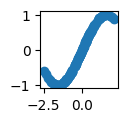

In [43]:
# create an input tensor of shape K_end.shape
with torch.cuda.device(0):
    input = torch.randn(K_end.shape, dtype=torch.float).cuda()
    gt_output = torch.sin(input)
    
input_jax = jnp.array(input.cpu())

import matplotlib.pyplot as plt
#recover the pixel value from matplotlib 
px = 1 / plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1,1, figsize=(100*px, 100*px))
line = ax.scatter(input.cpu().numpy(), gt_output.cpu().numpy())
plt.show()

In [44]:
K_end = kernel(log_A_real, A_imag, C, 0.1, 128)
K_f = torch.fft.rfft(K_end, n=2*L)
U_f = torch.fft.rfft(input, n=2*L)

In [45]:
y = torch.fft.irfft(K_f * U_f, n=2*L)[..., :L]

In [46]:
y.shape

torch.Size([128])

In [47]:
L

128

In [48]:
K_f_jax = jnp.fft.rfft(K_end_jax, n=2*L)
U_f_jax = jnp.fft.rfft(input_jax, n=2*L)
y_jax = jnp.fft.irfft(K_f_jax * U_f_jax, n=2*L)[..., :L]

In [49]:
jnp.allclose(y_jax, jnp.array(y.cpu()))

Array(True, dtype=bool)